In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [26]:
'''
2) Gradient Descent for Regression
'''
GRANULARITY = 50
FIGSIZE = [10, 7]
# One degree polynomial will fit this model
MAX_DEGREE = 1

train_2 = pd.read_csv(r'./Datasets/Dataset_2_train.csv', header=None)
valid_2 = pd.read_csv(r'./Datasets/Dataset_2_valid.csv', header=None)
test_2 = pd.read_csv(r'./Datasets/Dataset_2_test.csv', header=None)

example_set = {'train': train_2, 'valid': valid_2, 'test': test_2}
output_set = {}

print(example_set['train'].head())

          0         1   2
0  1.134362  8.755218 NaN
1  0.628288  6.080669 NaN
2  0.914297  7.154124 NaN
3  0.795270  6.725596 NaN
4  1.386819  9.262608 NaN


In [27]:
def fit(X, y, lambda_reg=0):
    '''
    Uses least-squares closed-form solution to obtain the optimal weights

    :param X: The input matrix of shape N x M
    :param y: The output vector N x 1
    :param lambda_reg: The regularization term. lambda_reg=0 means no regularization
    :return: The optimal weights as an M x 1 vector
    '''
    identity = np.identity(MAX_DEGREE + 1)
    # identity[0, 0] = 0 # We do not penalize the bias term

    X_square = np.matmul(np.transpose(X), X) + lambda_reg * identity
    X_square_inverse = np.linalg.pinv(X_square)
    weights = np.matmul(np.matmul(X_square_inverse, np.transpose(X)), y)

    return weights


def mean_square_error(X, y, W):
    '''
    Comptes the MSE of the dataset
    :param X: The input matrix of shape N x M
    :param y: The output vector N x 1
    :param W: Weights M x 1
    :return: MSE
    '''
    y_hat = np.matmul(X, W)
    mean_square_err = np.sum(np.square(y - y_hat)) / len(y)

    return mean_square_err


In [28]:
# Preprocessing input (separating X and y, adding bias column of 1s)
for key in example_set:
    output_set[key] = example_set[key][1]
    example_set[key].drop([1, 2], axis=1, inplace=True)
    example_set[key].columns = [1]
    example_set[key][0] = 1.
    example_set[key] = example_set[key][[0, 1]]
    
print(example_set['train'].head())
print(output_set['train'].head())

     0         1
0  1.0  1.134362
1  1.0  0.628288
2  1.0  0.914297
3  1.0  0.795270
4  1.0  1.386819
0    8.755218
1    6.080669
2    7.154124
3    6.725596
4    9.262608
Name: 1, dtype: float64


In [29]:
# Generating powers to MAX_DEGREE (which is 1 in this case for a straight line. No need to run this at all honestly, but this is general I wrote.
for i in range(2, MAX_DEGREE + 1):
    for _, df in example_set.items():
        df[i] = np.power(df[1], i)
        
print(example_set['train'].head())

     0         1
0  1.0  1.134362
1  1.0  0.628288
2  1.0  0.914297
3  1.0  0.795270
4  1.0  1.386819


In [30]:
# Convert to numpy arrays for faster descent
for key in example_set:
    example_set[key] = np.array(example_set[key], dtype=np.float64)
    output_set[key] = np.array(output_set[key], dtype=np.float64)


In [31]:
# Sanity check: Check against polyfit and our least squares fit to see if SGD is accurate. Note: I am ONLY using polyfit to check my answers
# See below for SGD implementation
weights_poly = np.polyfit(example_set['train'][:, 1], output_set['train'], MAX_DEGREE)[::-1]
weights_normal = fit(example_set['train'], output_set['train'])
print('Polyfit weights:', weights_poly)
print('Least Squares weights:', weights_normal)


Polyfit weights: [3.57652222 4.32027406]
Least Squares weights: [3.57652222 4.32027406]


In [33]:
'''
Define algorithm parameters
'''
ALPHA = 1e-6 # step size
EPOCHS = 20001 # iterations over all examples

# x axis for fit curve (used for plotting the model)
x_axis = pd.DataFrame(np.ones(GRANULARITY))
x_axis[1] = np.arange(0, 2, 2 / GRANULARITY)
for i in range(2, MAX_DEGREE + 1):
    x_axis[i] = pow(x_axis[1], i)

weights_original = np.random.uniform(high=5., size=[MAX_DEGREE + 1]) # Randomly initialize weights w = [w0, w1]
# weights_original = np.array([5, 6], dtype=np.float64)
print('Weights initialized randomly to:', weights_original)
X = example_set['train']
y = output_set['train']


Weights initialized randomly to: [2.93556514 3.79224368]


In [34]:
def visualize(W, visualize_all=False, X=None, y=None, title_for_all="", title_for_x="", save_all_as=None, save_x_as=None):
    '''
    Convenience function used for plotting
    :param W: The weights of the model
    :param visualize_all: Visualize all sets
    :param X: Visualize the given input X
    :param y: The output associated with input X
    :param title_for_all: Title for plot if visualize_all is set
    :param title_for_x: Title for plot if X is given
    :param save_all_as: Save the plot generated if visualize_all is set
    :param save_x_as: Save the plot generated for input X and associated output y
    '''
    global x_axis
    model_fit = np.matmul(x_axis, W)

    # Visualize fit on all three sets of data
    fig_no = 1
    if visualize_all:
        plt.figure(fig_no, figsize=FIGSIZE)
        fig_no += 1
        for i, key in enumerate(example_set, 1):
            plt.subplot(len(example_set), 1, i)
            plt.scatter(example_set[key][:, 1], output_set[key])
            plt.plot(x_axis[1], model_fit, 'r--')
            plt.title(title_for_all + ": " + key.upper())
            plt.xlabel('x')
            plt.ylabel('y')
            # plt.ylim([-22, 40])
        plt.tight_layout()
        if save_all_as:
            plt.savefig('./plots/' + save_all_as,  bbox_inches='tight')

    if not(X is None or y is None):
        plt.figure(fig_no, figsize=FIGSIZE)
        plt.scatter(X[:, 1], y)
        plt.plot(x_axis[1], model_fit, 'r--')
        plt.title(title_for_x)
        plt.xlabel('x')
        plt.ylabel('y')
        # plt.ylim([-22, 40])
        if save_x_as:
            plt.savefig('./plots/' + save_x_as,  bbox_inches='tight')
    plt.show()


In [35]:
'''
Try gradient descent first just for fun with ALPHA=1e-2. SGD is coming up next. 
'''
# Copy of randomly initialized weights
weights_GD = np.copy(weights_original)
N = len(X)
for epoch in range(EPOCHS):
    weights_GD = weights_GD - 1e-2 / N * np.matmul(np.transpose(X), np.matmul(X, weights_GD) - y)

# We can see that Gradient descent gives us the same results as np.polyfit and our closed form least-squares solution
print('Weights from Gradient Descent:', weights_GD)


Weights from Gradient Descent: [3.57652222 4.32027406]


In [36]:
'''
Stochastic gradient descent
'''

def plot(X, y, x_axis, weights, epoch):
    '''
    Helper for plotting updates during SGD
    '''
    model_fit = np.matmul(x_axis, weights)
    plt.scatter(X[:, 1], y, s=10)
    plt.plot(x_axis[1], model_fit, 'r--')
    plt.title('Part 3: Fit after ' + str(epoch) + ' epochs')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim(ymin=0, ymax=12)
    plt.xlim(xmax=1.6)
    plt.show()

def SGD(X, y, epochs, weights, alpha, plot_at_epoch=None):
    '''
    Returns the optimal weights, train MSE and valid MSE for the dataset.
    :param X: The training set N x M
    :param y: The actual output of the training set N x 1
    :param epochs: The number of iterations over all training sets
    :param weights: A M x 1 vector representing the weights
    :param alpha: The step size used for descent.
    :param plot_at_epoch: If specified, updates with plots every plot_at_epoch epochs to indicate progress of SGD
    :return: The optimal weights, train MSE and valid MSE
    '''
    global x_axis
    N = len(X)
    train_mse = []
    valid_mse = []

    for epoch in range(epochs):
        if plot_at_epoch and epoch % plot_at_epoch == 0:
           plot(X, y, x_axis, weights, epoch)
        # Iterate over all N examples
        for i in range(N):
            weights = weights - alpha * (np.sum((X[i] * weights)) - y[i]) * X[i]
        train_mse.append(mean_square_error(X, y, weights))
        valid_mse.append(mean_square_error(example_set['valid'], output_set['valid'], weights))

    return weights, train_mse, valid_mse


In [37]:
weights, train_mse, valid_mse = SGD(X, y, EPOCHS, np.copy(weights_original), ALPHA)
print('Weights at end:', weights)

# Display MSEs for each set
for key in example_set:
    print('MSE for', key, 'set with 1e-6:', mean_square_error(example_set[key], output_set[key], weights))


Weights at end: [3.57113867 4.32650767]
MSE for train set with 1e-6: 0.09551512850546588
MSE for valid set with 1e-6: 0.0738707722246916
MSE for test set with 1e-6: 0.0693694166121095


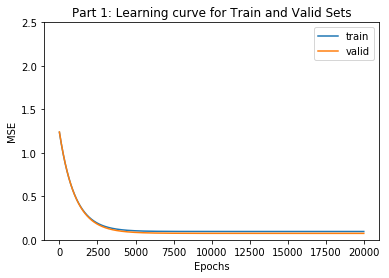

In [38]:
# Plot the learning curve for training and valid sets
plt.plot(np.arange(0, EPOCHS, 1), train_mse, label='train')
plt.plot(np.arange(0, EPOCHS, 1), valid_mse, label='valid')
plt.title('Part 1: Learning curve for Train and Valid Sets')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.ylim(ymin=0, ymax=2.5)
plt.show()


cur alpha: 1e-06


cur alpha: 5e-06


cur alpha: 1e-05


cur alpha: 5e-05


cur alpha: 0.0001


cur alpha: 0.0005


cur alpha: 0.001


cur alpha: 0.005


cur alpha: 0.01


cur alpha: 0.05


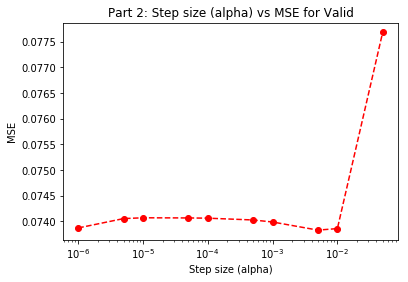

Best alpha: 0.005


In [39]:
'''
Part 2) Choose best step size ALPHA using validation data
'''
best_alpha = -1
lowest_mse = 99999
alphas = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]
MSEs = []

for cur_alpha in alphas:
    print('cur alpha:', cur_alpha)
    weights, _, _ = SGD(X, y, EPOCHS, np.copy(weights_original), cur_alpha)
    mse_for_valid = mean_square_error(example_set['valid'], output_set['valid'], weights)
    MSEs.append(mse_for_valid)
    if mse_for_valid < lowest_mse:
        lowest_mse = mse_for_valid
        best_alpha = cur_alpha

plt.plot(alphas, MSEs, 'ro')
plt.plot(alphas, MSEs, 'r--')
plt.title('Part 2: Step size (alpha) vs MSE for Valid')
plt.xlabel('Step size (alpha)')
plt.xscale('log')
plt.ylabel('MSE')
plt.show()

print('Best alpha:', best_alpha)


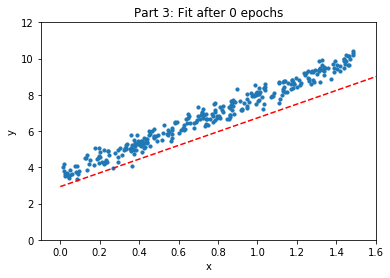

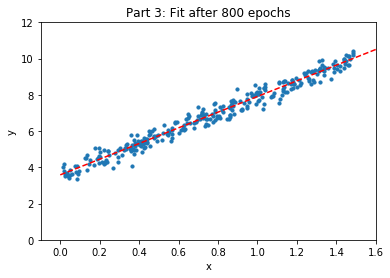

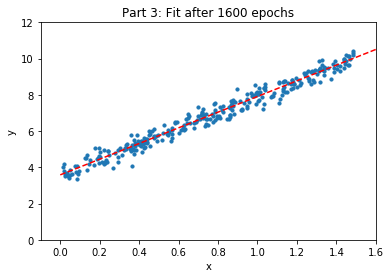

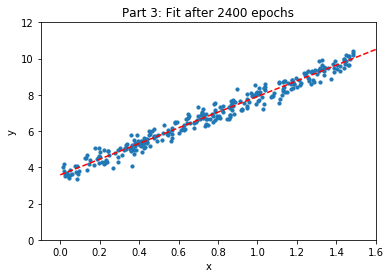

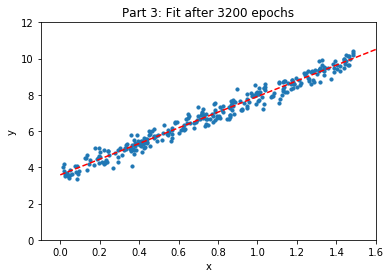

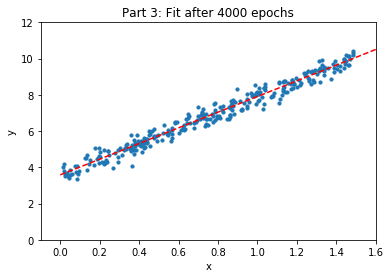

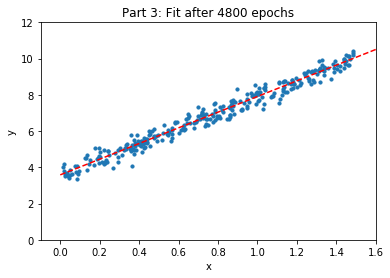

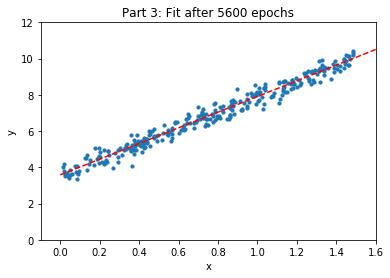

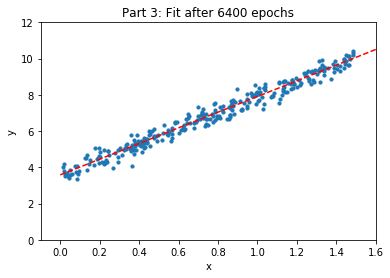

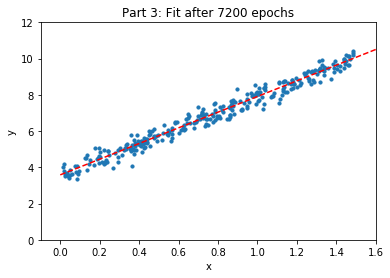

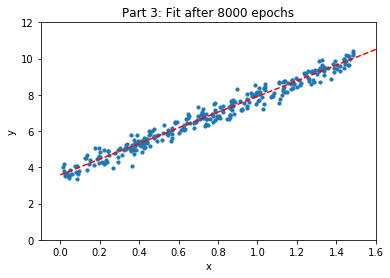

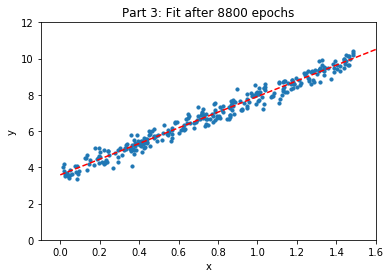

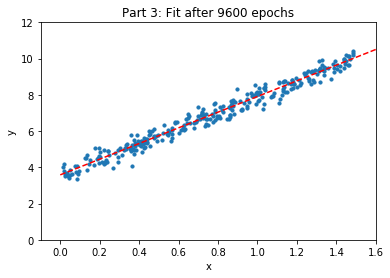

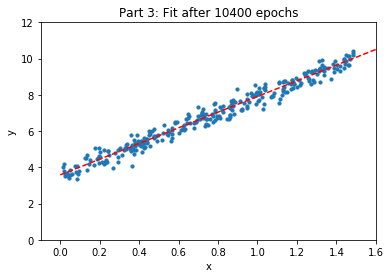

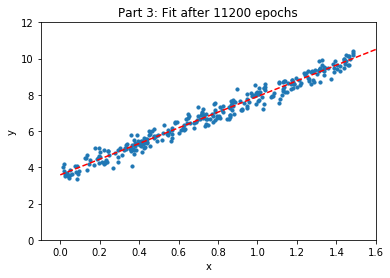

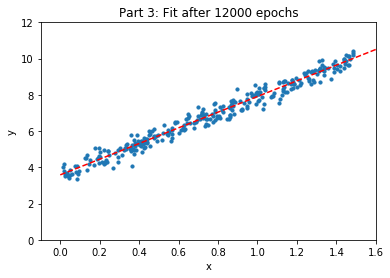

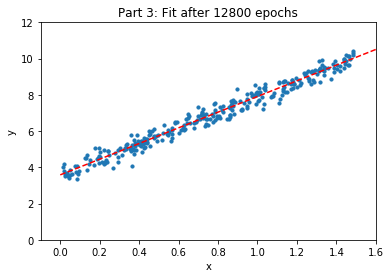

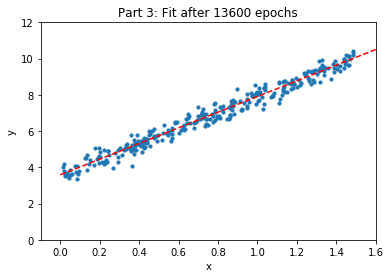

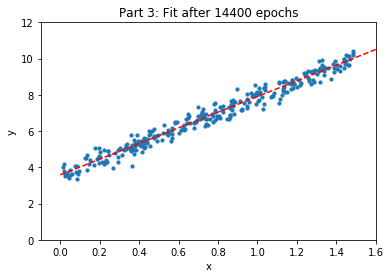

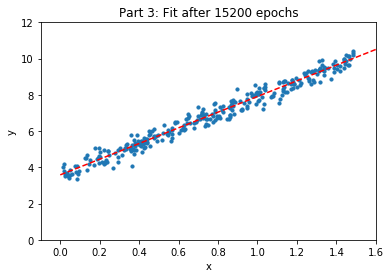

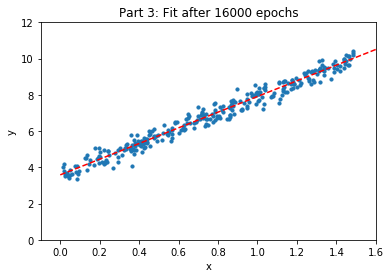

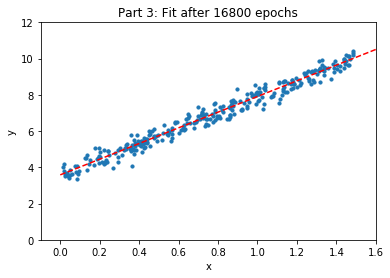

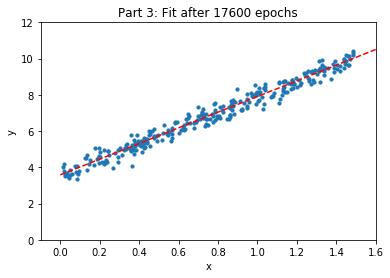

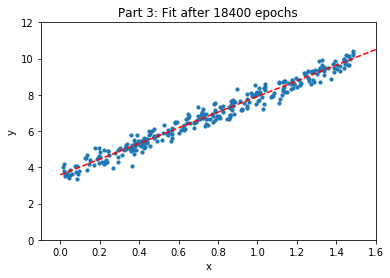

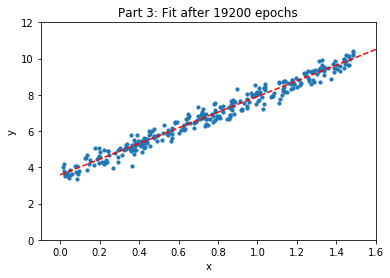

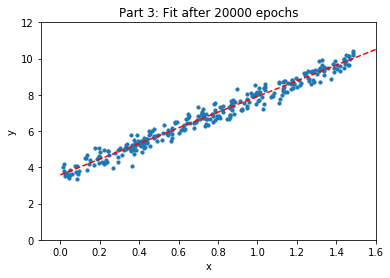

MSE for train set with best_alpha: 0.09563903823720046
MSE for valid set with best_alpha: 0.07382834588982806
MSE for test set with best_alpha: 0.06925595820892748


In [40]:
# Obtain optimal weights using best_alpha
weights_opt, _, _ = SGD(X, y, EPOCHS, np.copy(weights_original), best_alpha, 800)
# Display MSEs for each set
for key in example_set:
    print('MSE for', key, 'set with best_alpha:', mean_square_error(example_set[key], output_set[key], weights_opt))
    

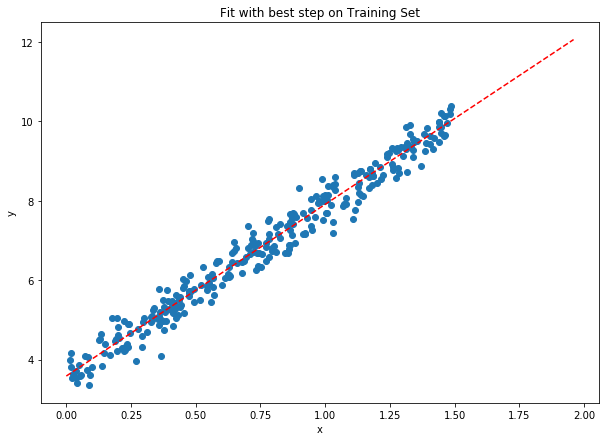

In [41]:
visualize(weights_opt, X=example_set['train'], y=output_set['train'], title_for_x='Fit with best step on Training Set')

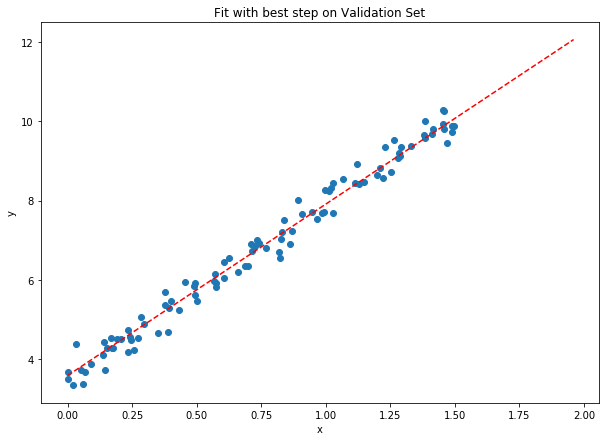

In [42]:
visualize(weights_opt, X=example_set['valid'], y=output_set['valid'], title_for_x='Fit with best step on Validation Set')

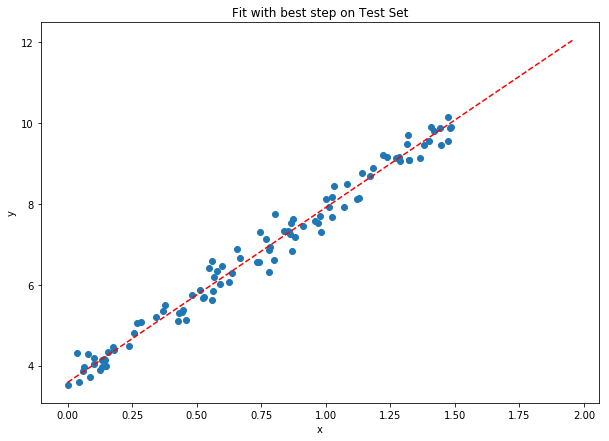

In [43]:
visualize(weights_opt, X=example_set['test'], y=output_set['test'], title_for_x='Fit with best step on Test Set')